In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold

import scipy.stats as stats

from tqdm.notebook import trange, tqdm

from utils import get_label, get_multi_label, plot_roc, evaluate, Imputer, Vectorizer, Splitter
from models import WeightedLogisticRegression

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
def label_from_multi(y_multi):
    return torch.tensor([1 if y == 0 else 0 for y in y_multi]).float()

data = pd.read_csv("data/train.tsv", sep="\t")
x_all, y_all_multi = data.drop("label", axis=1), get_multi_label(data)
x_train, x_test, y_train_multi, y_test_multi = train_test_split(data.drop("label", axis=1), get_multi_label(data), random_state=RANDOM_SEED)
y_train = label_from_multi(y_train_multi)
y_test = label_from_multi(y_test_multi)
y_all = label_from_multi(y_all_multi)

In [214]:
impute_vectorize = Pipeline([
    ("imputer", Imputer), ("vectorizer", Vectorizer)
])

split_vectorize = Pipeline([
    ("splitter", Splitter), ("vectorizer", Vectorizer)
])

column_transformer = ColumnTransformer([
       ("statement_vectorizer", Vectorizer ,"statement"),
        ("subject_vectorizer", split_vectorize, "subject"),
        ("job", impute_vectorize, "speaker_job"),
        ("state", impute_vectorize, "state"),
        ("party", impute_vectorize, "party"),
        ("context", impute_vectorize, "context")
    ])


g = 0.6
loss_weights = (1 - g, 1, 1 + g, 1 + 2*g, 1 + 3*g)


pipe_weighted = Pipeline([
    ("get_features", column_transformer),
    ("predict", WeightedLogisticRegression(loss_weights=loss_weights, lr=0.1, l1=0.0, l2=0.0002, max_iter=1000, tol=1e-6, plot_loss=False, verbose=False))
])


pipe_standard = Pipeline([
    ("get_features", column_transformer),
    ("predict", LogisticRegression(max_iter=1000, tol=1e-6, C=0.64))
])

In [215]:
kf = KFold(n_splits=100)
kf.get_n_splits(x_all);

In [216]:
roc_aucs_weighted = []
roc_aucs_standard = []

In [217]:
for train_index, test_index in tqdm(kf.split(x_all)):
    x_train, x_test = x_all.iloc[train_index], x_all.iloc[test_index]
    y_train_multi, y_test_multi = y_all_multi[train_index], y_all_multi[test_index]
    y_train = label_from_multi(y_train_multi)
    y_test = label_from_multi(y_test_multi)
    
    pipe_weighted.fit(x_train, y_train_multi)
    roc_aucs_weighted.append(evaluate(pipe_weighted, x_test, y_test, verbose=False))
    
    pipe_standard.fit(x_train, y_train)
    roc_aucs_standard.append(evaluate(pipe_standard, x_test, y_test, verbose=False))

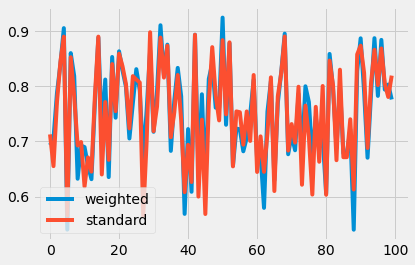

In [218]:
plt.plot(roc_aucs_weighted, label="weighted")
plt.plot(roc_aucs_standard, label="standard")
plt.legend();

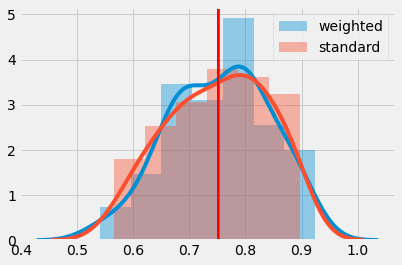

In [219]:
sns.distplot(roc_aucs_weighted, label="weighted")
plt.axvline(np.mean(roc_aucs_weighted), linewidth=2)
sns.distplot(roc_aucs_standard, label="standard")
plt.axvline(np.mean(roc_aucs_standard), color="red", linewidth=2)
plt.legend()

Differences are not statistically significant.

In [220]:
stats.wilcoxon(roc_aucs_weighted, roc_aucs_standard, alternative="greater")

WilcoxonResult(statistic=2644.0, pvalue=0.34121032793679573)

In [221]:
stats.ttest_ind(roc_aucs_weighted, roc_aucs_standard)

Ttest_indResult(statistic=0.18265031429152737, pvalue=0.8552592823024994)

In [222]:
np.mean(roc_aucs_weighted), np.mean(roc_aucs_standard)

(0.7532519885506201, 0.7509497543343393)

In [223]:
np.std(roc_aucs_weighted), np.std(roc_aucs_standard)

(0.08845654059239713, 0.08890534003176304)

In [224]:
f = np.var(roc_aucs_weighted) / np.var(roc_aucs_standard)
f

0.9899293640609923

In [225]:
stats.f.cdf(f, 100, 100)

0.4798691581860961

In [226]:
stats.levene(roc_aucs_weighted, roc_aucs_standard, center="median")

LeveneResult(statistic=0.029792222146060362, pvalue=0.8631388274370031)

In [227]:
np.max(roc_aucs_weighted), np.max(roc_aucs_standard)

(0.9244897959183673, 0.8979591836734694)

In [228]:
np.min(roc_aucs_weighted), np.min(roc_aucs_standard)

(0.5400238948626046, 0.5653061224489796)

In [229]:
np.median(roc_aucs_weighted), np.median(roc_aucs_standard)

(0.7654830782630335, 0.7547024985883681)